# broad nuclei - Mask R-CNN - train

In [26]:
import os
import sys
import re
import cv2
import time
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.morphology import label

sys.path.append('/Users/tfarrell/Dropbox/projects/mls_data_science_bowl2018/Mask_RCNN/')
import utils
import visualize
import broad_nuclei
from model import log
import broad_nuclei_model as modellib

%matplotlib inline 

# root directory of the project
ROOT_DIR = os.getcwd()
DATA_DIR = "/Users/tfarrell/Data/data_science_bowl_2018/"

# directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# local path to trained weights file
COCO_MODEL_PATH = os.path.join(DATA_DIR, "mask_rcnn_coco.h5")
# download COCO pre-trained weights, to init the model 
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [2]:
config = broad_nuclei.NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
IMG_CHANNELS                   3
IMG_HEIGHT                     720
IMG_WIDTH                      720
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES              

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """
    Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

In [4]:
# Training dataset
dataset_train = broad_nuclei.NucleiDataset()
dataset_train.load_dataset(DATA_DIR, 'train', config.IMG_HEIGHT, config.IMG_WIDTH)
dataset_train.prepare()

# Validation dataset
dataset_val = broad_nuclei.NucleiDataset()
dataset_val.load_dataset(DATA_DIR, 'validate', config.IMG_HEIGHT, config.IMG_WIDTH)
dataset_val.prepare()

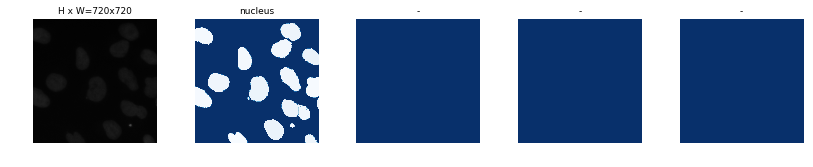

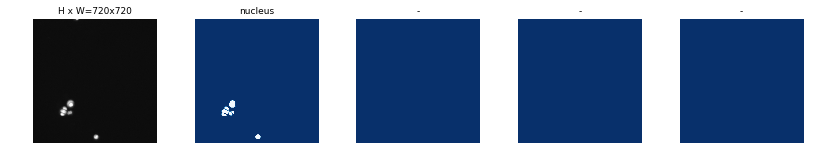

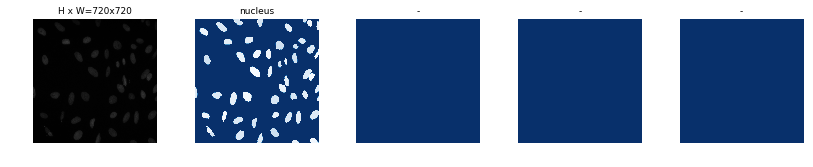

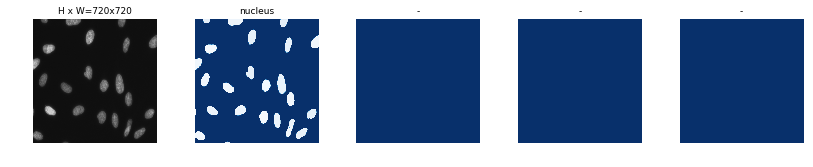

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id, config.IMG_HEIGHT, 
                                     config.IMG_WIDTH, config.IMG_CHANNELS)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [6]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [7]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [8]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/tfarrell/Dropbox/projects/mls_data_science_bowl2018/logs/nuclei20180205T2219/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_con

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 12111s 121s/step - loss: 1.7906 - rpn_class_loss: 0.1576 - rpn_bbox_loss: 0.3088 - mrcnn_class_loss: 0.4237 - mrcnn_bbox_loss: 0.3730 - mrcnn_mask_loss: 0.5274 - val_loss: 0.8816 - val_rpn_class_loss: 0.0323 - val_rpn_bbox_loss: 0.1080 - val_mrcnn_class_loss: 0.2353 - val_mrcnn_bbox_loss: 0.1465 - val_mrcnn_mask_loss: 0.3595


In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /Users/tfarrell/Dropbox/projects/mls_data_science_bowl2018/logs/nuclei20180205T2219/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/2
100/100 [==============================] - 18667s 187s/step - loss: 1.1333 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 0.2004 - mrcnn_class_loss: 0.3095 - mrcnn_bbox_loss: 0.1908 - mrcnn_mask_loss: 0.3715 - val_loss: 0.9983 - val_rpn_class_loss: 0.0442 - val_rpn_bbox_loss: 0.1396 - val_mrcnn_class_loss: 0.3466 - val_mrcnn_bbox_loss: 0.1302 - val_mrcnn_mask_loss: 0.3377


In [14]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(DATA_DIR, "mask_rcnn_broad_nuclei.h5")
model.keras_model.save_weights(model_path)

## Detection

In [15]:
class InferenceConfig(broad_nuclei.NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /Users/tfarrell/Dropbox/projects/mls_data_science_bowl2018/logs/nuclei20180205T2219/mask_rcnn_nuclei_0002.h5


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    1.00000  max:  912.00000
gt_class_id              shape: (158,)                min:    1.00000  max:    1.00000
gt_bbox                  shape: (158, 4)              min:  112.00000  max:  912.00000
gt_mask                  shape: (1024, 1024, 158)     min:    0.00000  max:  255.00000


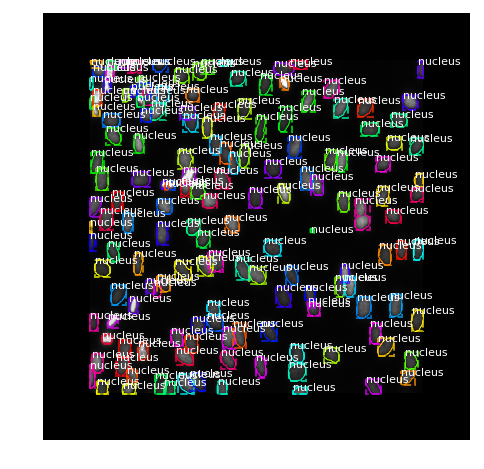

In [16]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000


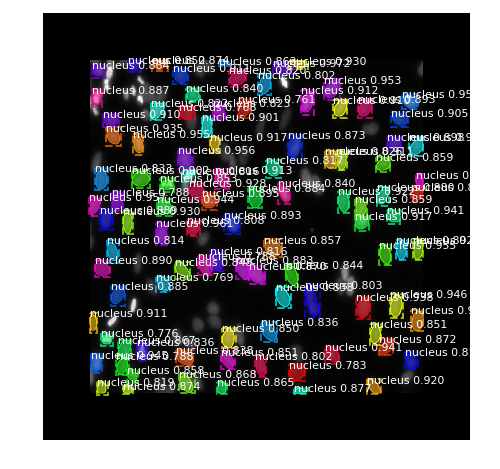

In [17]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [18]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.8354542591443197


## Test

In [19]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [21]:
# Test dataset
dataset_test = broad_nuclei.NucleiDataset()
dataset_test.load_dataset(DATA_DIR, 'test', config.IMG_HEIGHT, config.IMG_WIDTH)
dataset_test.prepare()

In [36]:
rles = []
test_ids = []
for id_ in dataset_test.image_ids:
    # predict
    img = dataset_test.load_image(id_, config.IMG_HEIGHT, 
                                  config.IMG_WIDTH, config.IMG_CHANNELS)
    img_info = dataset_test.image_info[id_]
    results = model.detect([img])
    masks = results[0]['masks']
    # run-length encoding
    rle = list(prob_to_rles(masks))
    rles.extend(rle)
    test_ids.extend([img_info['id']] * len(rle))

In [30]:
import pandas as pd

In [37]:
# Create submission DataFrame
output = pd.DataFrame()
output['ImageId'] = test_ids
output['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
output.to_csv(os.path.join(DATA_DIR, 'stage1_submission-maskrcnn_20180210.csv'), index=False)